This notebook aims to build the best model using only gradient boosting (CatBoost) and clinical risk factor features to predict TKR. Specifically it: 
- Builds a baseline model using logistic regression and 7 "core" clinical risk factor features (incl. KL Grade) 
- Performs feature selection on the full 600+ eligible risk factor features by iteratively fitting CatBoost models, dropping features in each iteration with negative feature importance on the validation set 
- Fits a final CatBoost model using the reduced feature set and evaluates on the unseen test set 

In [1]:
# mount our google drive onto colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# set that folder to be our working directory 
import os 
os.chdir("/content/gdrive/My Drive/oai-xray-tkr-klg")

In [3]:
# manually install some dependencies 
!pip install catboost==0.24 shap

     |████████████████████████████████| 65.8 MB 113 kB/s 
     |████████████████████████████████| 564 kB 41.6 MB/s 


In [4]:
import numpy as np
import pandas as pd

from tkr_methods.data_processing import split_train_val, separate_cat_num_features, coerce_categorical_features 
from tkr_methods.modeling import fit_eval_logit, fit_eval_catboost, select_features, cv_catboost

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

The combined data and variable descriptions were generated in the `Clinical-DataPrep.ipynb` notebook.

In [5]:
COHORT = 'data/KR_cohort_2021_10_28_with_splits_v2.csv'
DATA_FP = 'output/combined_clinical_data.csv'
DESC_FP = 'output/combined_clinical_variable_desc.csv'

In [6]:
cohort = pd.read_csv(COHORT)
cohort.info()
cohort.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Knee_ID             8957 non-null   object 
 1   id                  8957 non-null   int64  
 2   DATE                547 non-null    object 
 3   DAYS                547 non-null    float64
 4   Side                8957 non-null   object 
 5   KR_Label            8957 non-null   int64  
 6   Xray_HDF5_Filename  8957 non-null   object 
 7   Xray_HDF5_Exists    8957 non-null   int64  
 8   Eligible            8957 non-null   int64  
 9   Split               8932 non-null   object 
 10  TrainFold           6695 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 769.9+ KB


,Knee_ID,id,DATE,DAYS,Side,KR_Label,Xray_HDF5_Filename,Xray_HDF5_Exists,Eligible,Split,TrainFold
0,9002430_RIGHT,9002430,2010-02-15,1702.0,RIGHT,1,9002430_00m_RIGHT_KNEE.hdf5,1,1,train,2.0
1,9014797_RIGHT,9014797,2012-01-23,2681.0,RIGHT,1,9014797_00m_RIGHT_KNEE.hdf5,1,1,train,3.0
2,9015363_RIGHT,9015363,2008-10-15,1396.0,RIGHT,1,9015363_00m_RIGHT_KNEE.hdf5,1,1,train,1.0
3,9028418_RIGHT,9028418,2008-10-07,1360.0,RIGHT,1,9028418_00m_RIGHT_KNEE.hdf5,1,1,train,1.0
4,9030718_RIGHT,9030718,2008-11-05,1269.0,RIGHT,1,9030718_00m_RIGHT_KNEE.hdf5,1,1,train,2.0


In [7]:
df = pd.read_csv(DATA_FP)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Columns: 694 entries, V00ILLPWK1 to TrainFold
dtypes: float64(661), int64(30), object(3)
memory usage: 47.4+ MB


,V00ILLPWK1,P02KPN,P01KPACT30,P01BP30,P01TMJE6M,P01TMJF6M,V00SF1,V00SF2,V00SF3,V00SF4,V00SF5,V00SF6,V00SF7,V00SF8,V00SF9,V00SF10,V00SF11,V00SF12,V00KQOL1,V00KQOL2,V00KQOL3,V00KQOL4,V00KGLRS,P01KPACTCV,P01BPTOT,V00HSPSS,V00HSMSS,V00KOOSQOL,P01SXKOA,P01KPA30CV,P01TJE30CV,P01TJF30CV,P01TJE30WC,P01TJF30WC,P01BPDAYCV,P01BPBEDCV,P01BPACTCV,P01KSX,P01KPACDCV,P02KPMED,P02KINJ,P02KSURG,P02CNCR3,P01RAIA,P01ARTHOTH,P01ARTDOC,P01KPMED,P01HRS,V00HRTAT,V00HRTFAIL,V00BYPLEG,V00STROKE,V00ASTHMA,V00LUNG,V00ULCER,V00DIAB,V00KIDFXN,V00KIDTRAN,V00POLYRH,V00LIVDAM,V00CANCER,V00BONEFX,V00SPNFX,V00FALL,V00SMOKE,V00PIPE,V00DRNKAMT,V00DRKMORE,V00CESD1,V00CESD2,V00CESD3,V00CESD4,V00CESD5,V00CESD6,V00CESD7,V00CESD8,V00CESD9,V00CESD10,V00CESD11,V00CESD12,V00CESD13,V00CESD14,V00CESD15,V00CESD16,V00CESD17,V00CESD18,V00CESD19,V00CESD20,V00TYLEN,V00NSAIDS,V00NSAIDRX,V00COXIBS,V00NARCOT,V00SAME,V00MSM,V00DOXYCYC,V00PNMEDT,V00CHON,V00GLUC,V00KNINJ,V00GNRH,V00PTH,V00BISPHOS,V00CAM12,V00DIET12,V00VITM12,V00HERB12,V00RUBS12,V00BRAC12,V00YOGA12,V00RELA12,V00SPIR12,V00RX30,P02KPMEDCV,P01OADEGCV,P01OAHIPCV,P01OAHNDCV,P01OABCKCV,P01OAOTHCV,P01GOUTCV,P01OTARTCV,P01ARTDRCV,P01KPMEDCV,V00COMORB,V00FALLCV,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00SMOKER,V00SMKPKYR,V00PSMOKER,V00CESD,V00BISPTYP,V00CHNFQCV,V00GLCFQCV,V00HYINJCV,V00STINJCV,V00ACUTCV,V00ACUSCV,V00CHELCV,V00CHIRCV,V00FOLKCV,V00HOMECV,V00MASSCV,V00DIETCV,V00VITMCV,V00RUBCV,V00CAPSNCV,V00BRACCV,V00YOGACV,V00HERBCV,V00RELACV,V00SPIRCV,V00RXANALG,V00RXVLCXB,V00RXFLUOR,V00RXCLCTN,V00RXBISPH,P01RASTASV,V00RXIHYAL,V00RXRFCXB,V00RXNARC,V00RXISTRD,V00RXCOX2,V00RXCHOND,V00RXOTHAN,V00RXGLCSM,V00RXACTM,V00RXMSM,V00RXNSAID,V00RXASPRN,V00RXNTRAT,V00RXRALOX,V00RXVIT_D,V00RXOSTRD,V00RXCLCXB,V00RXTPRTD,V00RXSALIC,V00RXSAME,P01RATOTCV,V00OTHCAMC,V00OTHCAM,V00FFQ1,V00FFQSZ1,V00FFQ2,V00FFQ3,V00FFQ4,V00FFQ5,V00FFQ6,V00FFQSZ6,V00FFQ7,V00FFQ8,V00FFQSZ8,V00FFQ9,V00FFQSZ9,V00FFQ10,V00FFQ11,V00FFQ12,V00FFQSZ12,V00FFQ13,V00FFQSZ13,V00FFQ14,V00FFQSZ14,V00FFQ15,V00FFQ16,V00FFQSZ16,V00FFQ17,V00FFQSZ17,V00FFQ18,V00FFQ19,V00FFQSZ19,V00FFQ20,V00FFQSZ20,V00FFQ21,V00FFQSZ21,V00FFQ22,V00FFQ23,V00FFQSZ23,V00FFQ24,V00FFQSZ24,V00FFQ25,V00FFQSZ25,V00FFQ26,V00FFQ27,V00FFQ28,V00FFQSZ28,V00FFQ29,V00FFQSZ29,V00FFQ30,V00FFQ31,V00FFQSZ31,V00FFQ32,V00FFQ33,V00FFQ34,V00FFQ35,V00FFQ36,V00FFQ37,V00FFQ38,V00FFQSZ38,V00FFQ39,V00FFQ40,V00FFQ41,V00FFQSZ41,V00FFQ42,V00FFQ43,V00FFQ45,V00FFQSZ45,V00FFQ46,V00FFQ47,V00FFQSZ47,V00FFQ48,V00FFQ49,V00FFQSZ49,V00FFQ50,V00FFQ51,V00FFQSZ51,V00FFQ52,V00FFQ53,V00FFQ54,V00FFQ55,V00FFQSZ55,V00FFQ56,V00FFQSZ56,V00FFQ57,V00FFQSZ57,V00FFQ58,V00FFQSZ58,V00FFQ59,V00FFQSZ59,V00FFQ60,V00FFQ61,V00FFQSZ61,V00FFQ62,V00FFQ63,V00FFQ64,V00FFQ65,V00FFQ66,V00FFQ67,V00FFQ68,V00FFQ69,V00FFQ70,V00FFQ71,V00FFQ72,V00FFQ73,V00VIT1,V00VIT2,V00VIT3,V00VIT4,V00VIT5,V00VIT6,V00VIT7,V00VIT8,V00VIT9,V00VIT10,V00VIT11,V00VIT12,V00VIT13,V00FFQ90,V00MVIT1CV,V00STRTBCV,V00ANTOXCV,V00VITACV,V00BCARCV,V00VITECV,V00FOLATCV,V00CALCMCV,V00ZINCCV,V00IRONCV,V00SLNMCV,V00VITDCV,V00VITCCV,V00DTDFIB,V00SUPVITD,V00FIBVGFR,V00SUPB12,V00DTCAFFN,V00SRVFAT,V00DTAIU,V00DTCHOL,V00PCTCOL1,V00DTPHOS,V00DTVITC,V00DTB1,V00PCTXLS,V00SUPB2,V00PCTCOL9,V00DTVITK,V00DTRET,V00SUPVITE,V00SUPNIAC,V00DTANZN,V00DTLUT,V00BAPFAT,V00PCTCARB,V00PCTSWT,V00DTACAR,V00SUPCA,V00SRVGRN,V00SRVFRT,V00SUPFOL,V00DTBCAR,V00DTPROT,V00NWARNS,V00DTPOTA,V00DTSFAT,V00SUPVITC,V00DTOLEC,V00SUPBCAR,V00DTKCAL,V00BAPPROT,V00BAPCARB,V00SUPVITA,V00SUPB6,V00NFDSDAY,V00DTNIAC,V00FIBBEAN,V00DTNA,V00DTARE,V00DTLYC,V00DTFAT,V00PCTSMAL,V00SUPFE,V00SUPCU,V00DTB12,V00DTGEN,V00DTMETH,V00SUPZINC,V00SRVVEG,V00DTCALC,V00DTDAID,V00SRVMEAT,V00DTFE,V00FIBGRN,V00DTCYST,V00DTSF,V00PCTPROT,V00SRVDRY,V00DTB6,V00SUPB1,V00SUPSE,V00DTMG,V00PCTFAT,V00DTVITD,V00DTPROA,V00DTCARB,V00PCTALCH,V00DTFOL,V00DTLIN,V00PCTLARG,V00DTVITE,V00NSKIP,V00DTCRYP,V00PCTMEDS,V00DTRIBO,V00NERRORS,V00DTZINC,V00FFQFLG5,V00FFQFLG2,V00FFQFLG1,V00FFQFLG4,V00FFQFLG3,V00BPTERM,V00BPSYS,V00BPDIAS,V00RPAVG,V00MAXCIRC,V00CSTSGL,V00CSTREP1,V00CSTIME1,V00CSTREP2,V00C

In [8]:
desc = pd.read_csv(DESC_FP)
desc.info()
desc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VariableName     1711 non-null   object 
 1   Attribute        1711 non-null   object 
 2   Use in Analysis  1711 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.2+ KB


,VariableName,Attribute,Use in Analysis
0,P01RXRKOA,SV:Right knee baseline radiographic OA (defini...,1.0
1,P01LXRKOA,SV:Left knee baseline radiographic OA (definit...,1.0
2,V00URINHR1,EV:Urine collection: time collected (first col...,0.0
3,V00URINHR2,EV:Urine collection: time collected (repeat co...,0.0
4,V00BLDHRS1,EV:Phlebotomy: time venipuncture completed (fi...,0.0


# Process Data

In [9]:
# split train dataset into train/val/test 
train_val = df.query("Split=='train'")
train, val = split_train_val(df=train_val) 
test = df.query("Split=='test'")
print(f"train size: {len(train)}, val size: {len(val)}, test size: {len(test)}")

train size: 5017, val size: 1678, test size: 2237


# Train Model 

## Logistic Regression with Core Features (Baseline)

In [10]:
# use all core features 
_, _, logit_core_val_metrics = fit_eval_logit(
    cat_features=['P02SEX', 'P02RACE'], 
    num_features=['KNEE_V00XRKL', 'P01BMI', 'V00AGE', 'KNEE_P01INJL', 'KNEE_V00LKALNMT'], 
    train=train, val=val
)

Optimization terminated successfully.
         Current function value: 0.178505
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               KR_LABEL   No. Observations:                 5017
Model:                          Logit   Df Residuals:                     5007
Method:                           MLE   Df Model:                            9
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.2210
Time:                        02:31:34   Log-Likelihood:                -895.56
converged:                       True   LL-Null:                       -1149.6
Covariance Type:            nonrobust   LLR p-value:                1.050e-103
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -6.7483      0.776     -8.700      0.000      -8.269      -5.228
C(P02SEX)[T.2]      0.3901      0.140      2.793      0.005       0.116       0.664
C(P02RACE)[T.1]    -0.6645      0.414     -1.606      0.108      -1.475       0.146
C(P02RACE)[T.2]    -1.4348      0.444     -3.232      0.001      -2.305      -0.565
C(P02RACE)[T.3]     0.4589      0.637      0.720      0.471      -0.790       1.707
KNEE_V00XRKL        1.1083      0.066     16.802      0.000       0.979       1.238
P01BMI              0.0256      0.014      1.882      0.060      -0.001       0.052
V00AGE              0.0264      0.008      3.362      0.001       0.011       0.042
KNEE_P01INJL        0.0776      0.142      0.548      0.584      -0.200       0.355
KNEE_V00LKALNMT    -0.0120      0.016     -0.736      0.462      -0.044       0.020
===================================================================================
"""

{'logloss': 0.1729, 'accuracy': 0.9398, 'balanced_accuracy': 0.5324, 'auroc': 0.8501, 'auprc': 0.3586}


In [11]:
# instead of using 3 dummy variables for race, use just one indicating whether race is black 
_, _, _ = fit_eval_logit(
    cat_features=['P02SEX'], 
    num_features=['KNEE_V00XRKL', 'P01BMI', 'V00AGE', 'KNEE_P01INJL', 'KNEE_V00LKALNMT', 'P02RACE_IsBlack'],
    train=train, val=val
)

Optimization terminated successfully.
         Current function value: 0.179159
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               KR_LABEL   No. Observations:                 5017
Model:                          Logit   Df Residuals:                     5009
Method:                           MLE   Df Model:                            7
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.2181
Time:                        02:31:35   Log-Likelihood:                -898.84
converged:                       True   LL-Null:                       -1149.6
Covariance Type:            nonrobust   LLR p-value:                3.708e-104
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.2403      0.682    -10.613      0.000      -8.577      -5.903
C(P02SEX)[T.2]      0.4138      0.139      2.972      0.003       0.141       0.687
KNEE_V00XRKL        1.1129      0.066     16.865      0.000       0.984       1.242
P01BMI              0.0241      0.014      1.780      0.075      -0.002       0.051
V00AGE              0.0246      0.008      3.158      0.002       0.009       0.040
KNEE_P01INJL        0.0653      0.141      0.462      0.644      -0.212       0.343
KNEE_V00LKALNMT    -0.0111      0.016     -0.682      0.495      -0.043       0.021
P02RACE_IsBlack    -0.8081      0.189     -4.280      0.000      -1.178      -0.438
===================================================================================
"""

{'logloss': 0.1707, 'accuracy': 0.941, 'balanced_accuracy': 0.5376, 'auroc': 0.8544, 'auprc': 0.376}


In [12]:
# add age**2 since effect of age may not be linear 
_, _, logit_final_val_metrics = fit_eval_logit(
    cat_features=['P02SEX'], 
    num_features=['KNEE_V00XRKL', 'P01BMI', 'V00AGE', 'KNEE_P01INJL', 'KNEE_V00LKALNMT', 'P02RACE_IsBlack'],
    other_formula="I(V00AGE**2)", 
    train=train, val=val
)

Optimization terminated successfully.
         Current function value: 0.177503
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               KR_LABEL   No. Observations:                 5017
Model:                          Logit   Df Residuals:                     5008
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.2254
Time:                        02:31:35   Log-Likelihood:                -890.53
converged:                       True   LL-Null:                       -1149.6
Covariance Type:            nonrobust   LLR p-value:                8.865e-107
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -21.6536      3.804     -5.693      0.000     -29.109     -14.198
C(P02SEX)[T.2]      0.3662      0.140      2.613      0.009       0.092       0.641
KNEE_V00XRKL        1.1066      0.066     16.699      0.000       0.977       1.236
P01BMI              0.0215      0.014      1.579      0.114      -0.005       0.048
V00AGE              0.4933      0.121      4.079      0.000       0.256       0.730
KNEE_P01INJL        0.0788      0.142      0.557      0.578      -0.199       0.356
KNEE_V00LKALNMT    -0.0126      0.016     -0.772      0.440      -0.044       0.019
P02RACE_IsBlack    -0.8236      0.190     -4.341      0.000      -1.196      -0.452
I(V00AGE ** 2)     -0.0037      0.001     -3.894      0.000      -0.006      -0.002
===================================================================================
"""

{'logloss': 0.1704, 'accuracy': 0.941, 'balanced_accuracy': 0.5376, 'auroc': 0.8546, 'auprc': 0.3894}


We further attempted to add I(KNEE_V00LKALNMT^2) as well as iteratively drop insignificant features, but none improves AuPR so we stop here. 

## CatBoost with Core Features

Learning rate set to 0.047197
0:	learn: 0.6268676	test: 0.6259774	best: 0.6259774 (0)	total: 54.1ms	remaining: 54s
10:	learn: 0.3027071	test: 0.3024018	best: 0.3024018 (10)	total: 112ms	remaining: 10.1s
20:	learn: 0.2172935	test: 0.2172080	best: 0.2172080 (20)	total: 166ms	remaining: 7.74s
30:	learn: 0.1945899	test: 0.1949783	best: 0.1949783 (30)	total: 213ms	remaining: 6.67s
40:	learn: 0.1829297	test: 0.1840512	best: 0.1840512 (40)	total: 269ms	remaining: 6.3s
50:	learn: 0.1731277	test: 0.1770035	best: 0.1770035 (50)	total: 326ms	remaining: 6.06s
60:	learn: 0.1685823	test: 0.1740816	best: 0.1740816 (60)	total: 384ms	remaining: 5.92s
70:	learn: 0.1657515	test: 0.1727491	best: 0.1727491 (70)	total: 440ms	remaining: 5.75s
80:	learn: 0.1624892	test: 0.1718074	best: 0.1718074 (80)	total: 507ms	remaining: 5.75s
90:	learn: 0.1604062	test: 0.1712902	best: 0.1712902 (90)	total: 562ms	remaining: 5.61s
100:	learn: 0.1585334	test: 0.1709286	best: 0.1708710 (96)	total: 618ms	remaining: 5.5s
110:	l

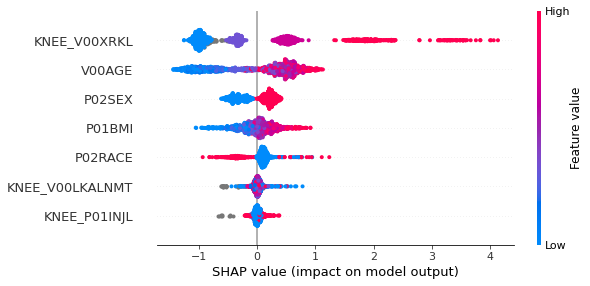

,Feature Id,LossFuncChgImportance,ShapImportance
0,KNEE_V00XRKL,0.065087,0.937385
1,P01BMI,0.002678,0.219037
2,V00AGE,0.002087,0.600690
3,P02RACE,0.002082,0.163090
4,P02SEX,0.001602,0.265264
5,KNEE_P01INJL,0.000107,0.050744
6,KNEE_V00LKALNMT,-0.000686,0.057573


{'logloss': 0.1695, 'accuracy': 0.941, 'balanced_accuracy': 0.556, 'auroc': 0.8559, 'auprc': 0.3646}


In [13]:
# use core features 
_, _, _, _, _ = fit_eval_catboost(
    train_df=train, val_df=val, plot_shap=True, max_shap_display=50, display_importances=True,
    cat_features=['P02SEX', 'P02RACE'], 
    num_features=['KNEE_V00XRKL', 'P01BMI', 'V00AGE', 'KNEE_P01INJL', 'KNEE_V00LKALNMT'])

Learning rate set to 0.047197
0:	learn: 0.6261035	test: 0.6253700	best: 0.6253700 (0)	total: 3.24ms	remaining: 3.23s
10:	learn: 0.2932199	test: 0.2921972	best: 0.2921972 (10)	total: 33.3ms	remaining: 2.99s
20:	learn: 0.2134564	test: 0.2127762	best: 0.2127762 (20)	total: 62.1ms	remaining: 2.9s
30:	learn: 0.1871608	test: 0.1875701	best: 0.1875701 (30)	total: 93.3ms	remaining: 2.92s
40:	learn: 0.1752093	test: 0.1778915	best: 0.1778915 (40)	total: 129ms	remaining: 3.02s
50:	learn: 0.1685016	test: 0.1734559	best: 0.1734559 (50)	total: 163ms	remaining: 3.03s
60:	learn: 0.1638104	test: 0.1710202	best: 0.1710202 (60)	total: 193ms	remaining: 2.97s
70:	learn: 0.1603277	test: 0.1701667	best: 0.1701667 (70)	total: 223ms	remaining: 2.92s
80:	learn: 0.1573928	test: 0.1695199	best: 0.1694634 (79)	total: 263ms	remaining: 2.99s
90:	learn: 0.1547028	test: 0.1691270	best: 0.1690784 (88)	total: 304ms	remaining: 3.04s
100:	learn: 0.1527014	test: 0.1690719	best: 0.1690086 (99)	total: 338ms	remaining: 3.01s


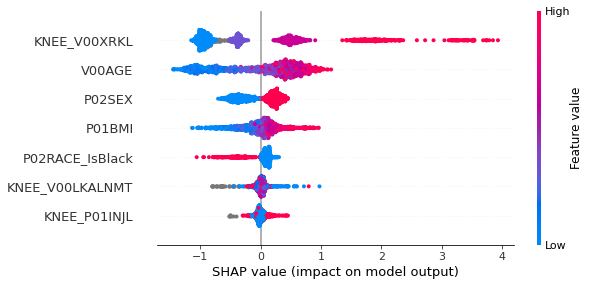

,Feature Id,LossFuncChgImportance,ShapImportance
0,KNEE_V00XRKL,0.064373,0.917807
1,P02RACE_IsBlack,0.003290,0.148029
2,P01BMI,0.002569,0.224059
3,V00AGE,0.002061,0.559225
4,P02SEX,0.001560,0.281395
5,KNEE_P01INJL,0.000120,0.059006
6,KNEE_V00LKALNMT,-0.000334,0.066265


{'logloss': 0.1682, 'accuracy': 0.941, 'balanced_accuracy': 0.5606, 'auroc': 0.8582, 'auprc': 0.3814}


In [14]:
# swap out categorical race for binary race
_, _, _, _, cb_core_val_metrics = fit_eval_catboost(
    train_df=train, val_df=val, plot_shap=True, max_shap_display=50, display_importances=True,
    cat_features=['P02SEX'], 
    num_features=['KNEE_V00XRKL', 'P01BMI', 'V00AGE', 'KNEE_P01INJL', 'KNEE_V00LKALNMT', 'P02RACE_IsBlack']
)

## CatBoost with Full Features

CatBoost can handle categorical variables without much pre-processing, but it does require that we identify which features are to be treated as categorical, and any categorical features can only take on string or integer types (not floats or nans). We go ahead and identify and convert our categorical features here. 

In [15]:
train_val = coerce_categorical_features(df=train_val)
train = coerce_categorical_features(df=train)
val = coerce_categorical_features(df=val)
test = coerce_categorical_features(df=test)

In [16]:
# let's go ahead and fit a CatBoost model using all eligible features 
id_cols = ['Knee_ID', 'ID', 'SIDE', 'KR_LABEL', 'Xray_HDF5_Filename', 'Xray_HDF5_Exists', 'Eligible', 'Split', 'TrainFold']
manual_exclude = ['V00SUPMG', 'P02KRS3CV', 'P01MRKCBCV', 'V00NNOSERV', 'P02KSURGCV', 'P02KRSCV', 'P02RACE'] 
all_features = [col for col in list(df.columns) if col not in id_cols and col not in manual_exclude]  
all_num_features, all_cat_features = separate_cat_num_features(df=df, feature_cols=all_features)
print(f"Full list of num clinical features retained: {all_num_features}")
print("")
print(f"Full list of cat clinical features retained: {all_cat_features}")

Full list of num clinical features retained: ['V00ILLPWK1', 'P02KPN', 'P01KPACT30', 'P01BP30', 'P01TMJE6M', 'P01TMJF6M', 'V00SF1', 'V00SF2', 'V00SF3', 'V00SF4', 'V00SF5', 'V00SF6', 'V00SF7', 'V00SF8', 'V00SF9', 'V00SF10', 'V00SF11', 'V00SF12', 'V00KQOL1', 'V00KQOL2', 'V00KQOL3', 'V00KQOL4', 'V00KGLRS', 'P01KPACTCV', 'P01BPTOT', 'V00HSPSS', 'V00HSMSS', 'V00KOOSQOL', 'P01SXKOA', 'P01KPA30CV', 'P01TJE30CV', 'P01TJF30CV', 'P01TJE30WC', 'P01TJF30WC', 'P01BPDAYCV', 'P01BPBEDCV', 'P01BPACTCV', 'P01KSX', 'P01KPACDCV', 'P02KPMED', 'P02KINJ', 'P02KSURG', 'P02CNCR3', 'P01RAIA', 'P01ARTHOTH', 'P01ARTDOC', 'P01KPMED', 'P01HRS', 'V00HRTAT', 'V00HRTFAIL', 'V00BYPLEG', 'V00STROKE', 'V00ASTHMA', 'V00LUNG', 'V00ULCER', 'V00DIAB', 'V00KIDFXN', 'V00KIDTRAN', 'V00POLYRH', 'V00LIVDAM', 'V00CANCER', 'V00BONEFX', 'V00SPNFX', 'V00FALL', 'V00SMOKE', 'V00PIPE', 'V00DRNKAMT', 'V00DRKMORE', 'V00CESD1', 'V00CESD2', 'V00CESD3', 'V00CESD4', 'V00CESD5', 'V00CESD6', 'V00CESD7', 'V00CESD8', 'V00CESD9', 'V00CESD10', 'V00

Learning rate set to 0.047197
0:	learn: 0.6375825	test: 0.6376084	best: 0.6376084 (0)	total: 67.5ms	remaining: 1m 7s
10:	learn: 0.3163896	test: 0.3174594	best: 0.3174594 (10)	total: 630ms	remaining: 56.6s
20:	learn: 0.2184682	test: 0.2218765	best: 0.2218765 (20)	total: 1.19s	remaining: 55.6s
30:	learn: 0.1804599	test: 0.1874959	best: 0.1874959 (30)	total: 1.76s	remaining: 55s
40:	learn: 0.1630677	test: 0.1769508	best: 0.1769508 (40)	total: 2.34s	remaining: 54.6s
50:	learn: 0.1511305	test: 0.1709327	best: 0.1709327 (50)	total: 2.9s	remaining: 54.1s
60:	learn: 0.1424379	test: 0.1685626	best: 0.1685448 (58)	total: 3.47s	remaining: 53.5s
70:	learn: 0.1359361	test: 0.1666851	best: 0.1666851 (70)	total: 4s	remaining: 52.3s
80:	learn: 0.1303609	test: 0.1660134	best: 0.1660134 (80)	total: 4.56s	remaining: 51.7s
90:	learn: 0.1259949	test: 0.1655916	best: 0.1654354 (88)	total: 5.09s	remaining: 50.8s
100:	learn: 0.1209908	test: 0.1647328	best: 0.1647099 (98)	total: 5.65s	remaining: 50.3s
110:	lea

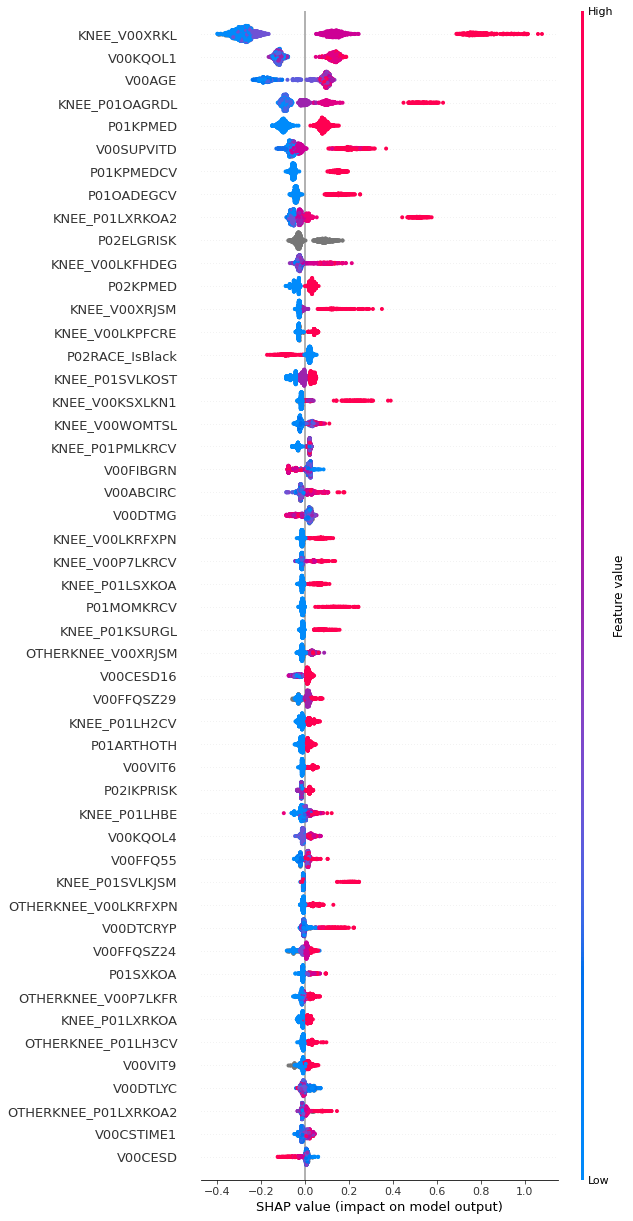

,Feature Id,LossFuncChgImportance,ShapImportance
0,KNEE_V00XRKL,1.445843e-02,0.323270
1,KNEE_P01OAGRDL,2.248972e-03,0.100031
2,P01OADEGCV,1.774489e-03,0.064730
3,KNEE_P01LXRKOA2,1.768992e-03,0.063151
4,KNEE_V00XRJSM,1.179257e-03,0.036925
5,P01KPMED,1.036371e-03,0.090079
6,V00AGE,8.759722e-04,0.116331
7,KNEE_V00LKRFXPN,8.333820e-04,0.024073
8,KNEE_V00LKFHDEG,8.235433e-04,0.037970
9,V00KQOL1,7.870735e-04,0.126770


{'logloss': 0.1631, 'accuracy': 0.9416, 'balanced_accuracy': 0.5746, 'auroc': 0.8823, 'auprc': 0.4009}


In [17]:
_, _, _, _, _ = fit_eval_catboost(
    train_df=train, val_df=val, plot_shap=True, max_shap_display=50, display_importances=True,
    cat_features=all_cat_features, num_features=all_num_features)

## CatBoost with Feature Selection

To select features, we iteratively run CatBoost and drop features that have negative importances (i.e. in theory makes our loss function worse off). We stop when all remaining features have positive importances. 

In [18]:
selected_features = select_features(full_features=all_features, train=train, val=val, max_iter=20)

Iteration 1
{'logloss': 0.1631, 'accuracy': 0.9416, 'balanced_accuracy': 0.5746, 'auroc': 0.8823, 'auprc': 0.4009}
Using 684 features, we obtain val loss of 0.16305490180596158
458 features have negative importances and may be dropped in next iter: ['V00ILLPWK1', 'P02KPN', 'P01KPACT30', 'P01BP30', 'P01TMJE6M', 'P01TMJF6M', 'V00SF2', 'V00SF4', 'V00SF5', 'V00SF6', 'V00SF7', 'V00SF8', 'V00SF11', 'V00KGLRS', 'P01KPACTCV', 'P01BPTOT', 'P01KPA30CV', 'P01TJE30CV', 'P01TJF30CV', 'P01TJE30WC', 'P01TJF30WC', 'P01BPDAYCV', 'P01BPBEDCV', 'P01BPACTCV', 'P01KSX', 'P01KPACDCV', 'P02KINJ', 'P02CNCR3', 'P01RAIA', 'P01HRS', 'V00HRTAT', 'V00HRTFAIL', 'V00BYPLEG', 'V00ASTHMA', 'V00LUNG', 'V00ULCER', 'V00DIAB', 'V00KIDFXN', 'V00KIDTRAN', 'V00POLYRH', 'V00LIVDAM', 'V00CANCER', 'V00BONEFX', 'V00SPNFX', 'V00FALL', 'V00PIPE', 'V00DRNKAMT', 'V00CESD2', 'V00CESD4', 'V00CESD5', 'V00CESD6', 'V00CESD7', 'V00CESD9', 'V00CESD11', 'V00CESD12', 'V00CESD15', 'V00CESD16', 'V00CESD17', 'V00CESD18', 'V00CESD19', 'V00CESD20

Learning rate set to 0.047197
0:	learn: 0.6292839	test: 0.6294741	best: 0.6294741 (0)	total: 5.3ms	remaining: 5.29s
10:	learn: 0.2886402	test: 0.2879428	best: 0.2879428 (10)	total: 64ms	remaining: 5.76s
20:	learn: 0.2033429	test: 0.2046085	best: 0.2046085 (20)	total: 117ms	remaining: 5.46s
30:	learn: 0.1711751	test: 0.1747385	best: 0.1747385 (30)	total: 166ms	remaining: 5.18s
40:	learn: 0.1554318	test: 0.1622838	best: 0.1622838 (40)	total: 214ms	remaining: 5s
50:	learn: 0.1466833	test: 0.1564954	best: 0.1564954 (50)	total: 269ms	remaining: 5s
60:	learn: 0.1392771	test: 0.1531870	best: 0.1531870 (60)	total: 315ms	remaining: 4.86s
70:	learn: 0.1330524	test: 0.1506728	best: 0.1506728 (70)	total: 375ms	remaining: 4.9s
80:	learn: 0.1278994	test: 0.1490250	best: 0.1490250 (80)	total: 427ms	remaining: 4.84s
90:	learn: 0.1231222	test: 0.1476806	best: 0.1476806 (90)	total: 474ms	remaining: 4.73s
100:	learn: 0.1190838	test: 0.1467254	best: 0.1467254 (100)	total: 530ms	remaining: 4.72s
110:	learn

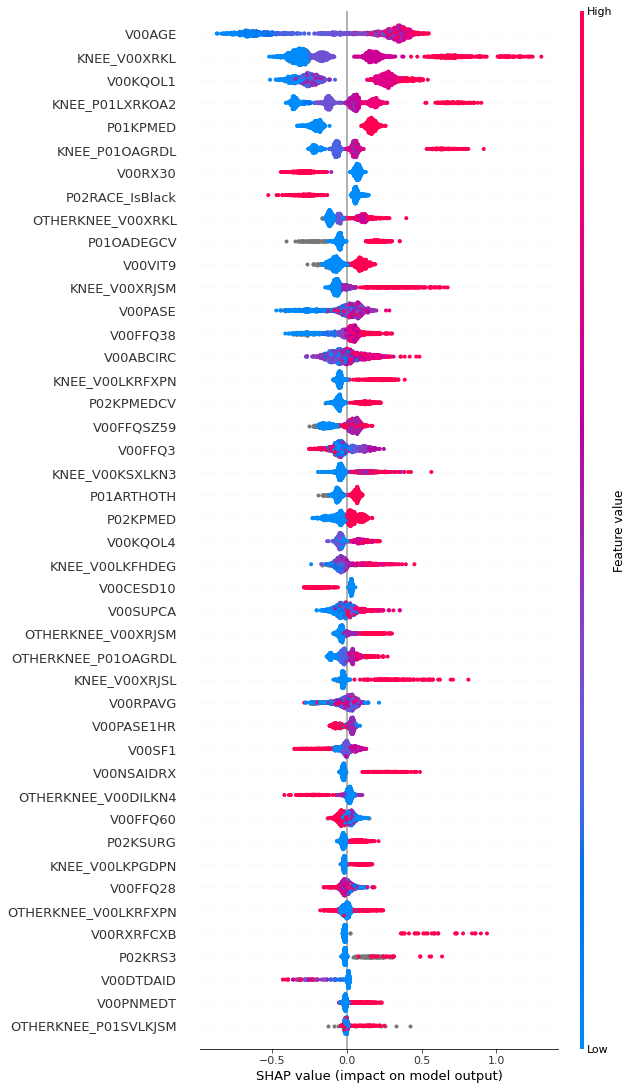

,Feature Id,LossFuncChgImportance,ShapImportance
0,KNEE_V00XRKL,0.013689,0.331073
1,KNEE_V00XRJSM,0.003535,0.086340
2,KNEE_P01LXRKOA2,0.003278,0.188562
3,KNEE_P01OAGRDL,0.002320,0.122063
4,KNEE_V00LKRFXPN,0.002177,0.078928
5,P02RACE_IsBlack,0.002004,0.101244
6,V00KQOL1,0.001937,0.283149
7,P01KPMED,0.001714,0.182893
8,V00AGE,0.001686,0.385848
9,KNEE_V00KSXLKN3,0.001480,0.067823


{'logloss': 0.1416, 'accuracy': 0.9458, 'balanced_accuracy': 0.5998, 'auroc': 0.9108, 'auprc': 0.5463}


In [19]:
selected_num_features, selected_cat_features = separate_cat_num_features(df=df, feature_cols=selected_features)
_, _, _, cb_final_val_importances, cb_final_val_metrics = fit_eval_catboost(
    train_df=train, val_df=val, plot_shap=True, max_shap_display=50, display_importances=True,
    cat_features=selected_cat_features, num_features=selected_num_features)

# Rename Selected Features

To facilitate interpretation of feature importances and shap values, we manually rename our selected features into more human-readable names. These along with the feature definitions, and how they are derived from the source features in our raw data sources, are saved in `SELECTED_FEATURES_DESC_FP`. To facilitate easy access to the selected features, we also output a version of the dataset with the renamed features along with the original cohort columns and labels to `SELECTED_FEATURES_DATA_FP`. 

In [20]:
SELECTED_FEATURES_DESC_FP = 'output/selected_clinical_variable_desc.csv'
SELECTED_FEATURES_DATA_FP = 'output/selected_clinical_data.csv'

In [21]:
selected_features_desc = pd.read_csv(SELECTED_FEATURES_DESC_FP)
selected_features_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Feature                       48 non-null     object
 1   FeatureRenamed                48 non-null     object
 2   Definition                    48 non-null     object
 3   InFinalCatBoost               48 non-null     int64 
 4   Source Feature(s)             48 non-null     object
 5   Source Feature(s) Definition  48 non-null     object
 6   Dataset                       48 non-null     object
 7   AttributeOf                   48 non-null     object
 8   Type                          48 non-null     object
 9   Formula                       15 non-null     object
dtypes: int64(1), object(9)
memory usage: 3.9+ KB


In [22]:
# check that the current notebook yielded the same set of selected features, else overwrite and load from that in CSV 
csv_selected_features = selected_features_desc.query("InFinalCatBoost==1")['Feature'].tolist() 
if set(selected_features) == set(csv_selected_features):
    print("Selected features from the current notebook run match the finalized results in CSV!")
else: 
    selected_features = csv_selected_features
    selected_num_features, selected_cat_features = separate_cat_num_features(df=df, feature_cols=selected_features)
    print("Selected features from the current notebook do not match finalized results in CSV! Overwriting selected features with the latter!")

Selected features from the current notebook run match the finalized results in CSV!


In [23]:
# rename dataframes in memory 
features_name_map = selected_features_desc.set_index('Feature')['FeatureRenamed'].to_dict()
for old_name, new_name in features_name_map.items():
    train[new_name] = train[old_name]
    train_val[new_name] = train_val[old_name]
    val[new_name] = val[old_name]
    test[new_name] = test[old_name]

In [24]:
# also output dataset with selected features renamed 
keep_cols = id_cols + selected_features
out_df = df[keep_cols].rename(columns=features_name_map)
out_df.to_csv(SELECTED_FEATURES_DATA_FP, index=False)
out_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Knee_ID                              8957 non-null   object 
 1   ID                                   8957 non-null   int64  
 2   SIDE                                 8957 non-null   int64  
 3   KR_LABEL                             8957 non-null   int64  
 4   Xray_HDF5_Filename                   8957 non-null   object 
 5   Xray_HDF5_Exists                     8957 non-null   int64  
 6   Eligible                             8957 non-null   int64  
 7   Split                                8932 non-null   object 
 8   TrainFold                            6695 non-null   float64
 9   KLGrade                              8416 non-null   float64
 10  CompositeOAGrade                     8954 non-null   float64
 11  Age                           

# Evaluate on Test Set

Here we refit our final model (and a number of baseline models) on the full renamed train set and evaluate on out-of-sample test set. Feature importances are also output to `CATBOOST_FEATURE_IMPORTANCES_FP` for analysis and discussion in poster / final report. 

In [25]:
CATBOOST_FEATURE_IMPORTANCES_FP = 'output/catboost_clinical_feature_importances.csv'
CATBOOST_TEST_PREDICTIONS_FP = 'output/catboost_clinical_test_preds.csv' 

In [26]:
# baseline 1: logit with final features 
logit_final_model, logit_final_preds, logit_final_test_metrics = fit_eval_logit(
    cat_features=['Sex'], 
    num_features=['KLGrade', 'BMI', 'Age', 'KneeInjury', 'KneeAlignment', 'RaceIsBlack'],
    other_formula="I(Age**2)",
    train=train_val, val=test
)

Optimization terminated successfully.
         Current function value: 0.175534
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               KR_LABEL   No. Observations:                 6695
Model:                          Logit   Df Residuals:                     6686
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.2339
Time:                        02:33:03   Log-Likelihood:                -1175.2
converged:                       True   LL-Null:                       -1534.1
Covariance Type:            nonrobust   LLR p-value:                1.056e-149
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -19.8598      3.183     -6.240      0.000     -26.098     -13.622
C(Sex)[T.2]       0.3808      0.121      3.143      0.002       0.143       0.618
KLGrade           1.1399      0.057     19.881      0.000       1.028       1.252
BMI               0.0282      0.012      2.392      0.017       0.005       0.051
Age               0.4353      0.102      4.274      0.000       0.236       0.635
KneeInjury        0.0453      0.123      0.369      0.712      -0.196       0.286
KneeAlignment    -0.0160      0.014     -1.129      0.259      -0.044       0.012
RaceIsBlack      -0.9869      0.174     -5.685      0.000      -1.327      -0.647
I(Age ** 2)      -0.0033      0.001     -4.104      0.000      -0.005      -0.002
=================================================================================
"""

{'logloss': 0.1789, 'accuracy': 0.9379, 'balanced_accuracy': 0.5165, 'auroc': 0.85, 'auprc': 0.2661}


Learning rate set to 0.047197
0:	learn: 0.6261035	test: 0.6253700	best: 0.6253700 (0)	total: 5.28ms	remaining: 5.27s
10:	learn: 0.2932199	test: 0.2921972	best: 0.2921972 (10)	total: 35.5ms	remaining: 3.19s
20:	learn: 0.2134564	test: 0.2127762	best: 0.2127762 (20)	total: 73.2ms	remaining: 3.41s
30:	learn: 0.1871608	test: 0.1875701	best: 0.1875701 (30)	total: 112ms	remaining: 3.5s
40:	learn: 0.1752093	test: 0.1778915	best: 0.1778915 (40)	total: 146ms	remaining: 3.42s
50:	learn: 0.1685016	test: 0.1734559	best: 0.1734559 (50)	total: 179ms	remaining: 3.34s
60:	learn: 0.1638104	test: 0.1710202	best: 0.1710202 (60)	total: 210ms	remaining: 3.24s
70:	learn: 0.1603277	test: 0.1701667	best: 0.1701667 (70)	total: 249ms	remaining: 3.26s
80:	learn: 0.1573928	test: 0.1695199	best: 0.1694634 (79)	total: 281ms	remaining: 3.19s
90:	learn: 0.1547028	test: 0.1691270	best: 0.1690784 (88)	total: 313ms	remaining: 3.13s
100:	learn: 0.1527014	test: 0.1690719	best: 0.1690086 (99)	total: 344ms	remaining: 3.06s
1

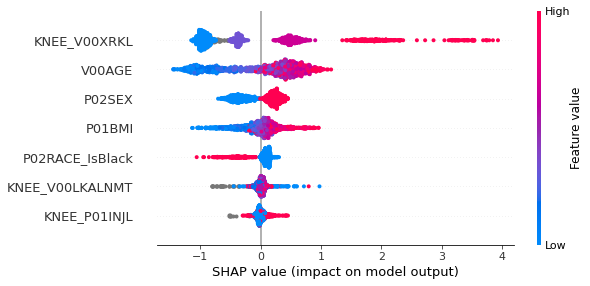

,Feature Id,LossFuncChgImportance,ShapImportance
0,KNEE_V00XRKL,0.064373,0.917807
1,P02RACE_IsBlack,0.003290,0.148029
2,P01BMI,0.002569,0.224059
3,V00AGE,0.002061,0.559225
4,P02SEX,0.001560,0.281395
5,KNEE_P01INJL,0.000120,0.059006
6,KNEE_V00LKALNMT,-0.000334,0.066265


{'logloss': 0.1863, 'accuracy': 0.9352, 'balanced_accuracy': 0.5288, 'auroc': 0.8277, 'auprc': 0.2666}


In [27]:
# baseline 2: catboost with core features 
cb_core_preds, cb_core_model, cb_core_shap, cb_core_test_importances, cb_core_test_metrics = fit_eval_catboost(
    train_df=train, val_df=val, test_df=test, plot_shap=True, max_shap_display=50, display_importances=True,
    cat_features=['P02SEX'], 
    num_features=['KNEE_V00XRKL', 'P01BMI', 'V00AGE', 'KNEE_P01INJL', 'KNEE_V00LKALNMT', 'P02RACE_IsBlack'])

Learning rate set to 0.047197
0:	learn: 0.6292839	test: 0.6294741	best: 0.6294741 (0)	total: 6.24ms	remaining: 6.23s
10:	learn: 0.2886402	test: 0.2879428	best: 0.2879428 (10)	total: 56ms	remaining: 5.04s
20:	learn: 0.2033429	test: 0.2046085	best: 0.2046085 (20)	total: 119ms	remaining: 5.55s
30:	learn: 0.1711751	test: 0.1747385	best: 0.1747385 (30)	total: 179ms	remaining: 5.59s
40:	learn: 0.1554318	test: 0.1622838	best: 0.1622838 (40)	total: 228ms	remaining: 5.32s
50:	learn: 0.1466833	test: 0.1564954	best: 0.1564954 (50)	total: 291ms	remaining: 5.42s
60:	learn: 0.1392771	test: 0.1531870	best: 0.1531870 (60)	total: 340ms	remaining: 5.24s
70:	learn: 0.1330524	test: 0.1506728	best: 0.1506728 (70)	total: 389ms	remaining: 5.08s
80:	learn: 0.1278994	test: 0.1490250	best: 0.1490250 (80)	total: 436ms	remaining: 4.94s
90:	learn: 0.1231222	test: 0.1476806	best: 0.1476806 (90)	total: 490ms	remaining: 4.9s
100:	learn: 0.1190838	test: 0.1467254	best: 0.1467254 (100)	total: 540ms	remaining: 4.8s
110:

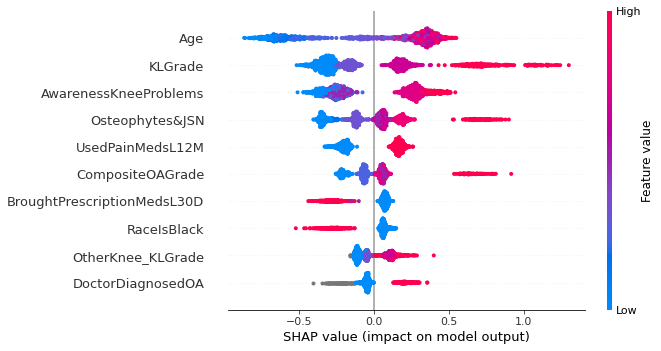

,Feature Id,LossFuncChgImportance,ShapImportance
0,KLGrade,0.013689,0.331073
1,BUkXRReading,0.003535,0.086340
2,Osteophytes&JSN,0.003278,0.188562
3,CompositeOAGrade,0.002320,0.122063
4,FlexionPain,0.002177,0.078928
5,RaceIsBlack,0.002004,0.101244
6,AwarenessKneeProblems,0.001937,0.283149
7,UsedPainMedsL12M,0.001714,0.182893
8,Age,0.001686,0.385848
9,KneeCatchHangUpL7D,0.001480,0.067823


{'logloss': 0.1702, 'accuracy': 0.9405, 'balanced_accuracy': 0.5798, 'auroc': 0.8747, 'auprc': 0.3732}


In [28]:
# final model: catboost with selected features 
cb_final_preds, cb_final_model, cb_final_shap, cb_final_test_importances, cb_final_test_metrics = fit_eval_catboost(
    train_df=train, val_df=val, test_df=test, plot_shap=True, max_shap_display=10, display_importances=True,
    cat_features=[features_name_map[col] for col in selected_cat_features], 
    num_features=[features_name_map[col] for col in selected_num_features])


In [29]:
# output test predictions and feature importances (shap + LossFuncChgImportance)
cb_final_preds.to_csv(CATBOOST_TEST_PREDICTIONS_FP, index=False)
cb_final_test_importances.to_csv(CATBOOST_FEATURE_IMPORTANCES_FP, index=False)
cb_final_test_importances

,Feature Id,LossFuncChgImportance,ShapImportance
0,KLGrade,0.013689,0.331073
1,BUkXRReading,0.003535,0.086340
2,Osteophytes&JSN,0.003278,0.188562
3,CompositeOAGrade,0.002320,0.122063
4,FlexionPain,0.002177,0.078928
5,RaceIsBlack,0.002004,0.101244
6,AwarenessKneeProblems,0.001937,0.283149
7,UsedPainMedsL12M,0.001714,0.182893
8,Age,0.001686,0.385848
9,KneeCatchHangUpL7D,0.001480,0.067823


In [30]:
# compile val and test metrics of final and baseline models 

logit_final_val_metrics_ = {f"val_{k}": v for (k,v) in logit_final_val_metrics.items()}
cb_core_val_metrics_ = {f"val_{k}": v for (k,v) in cb_core_val_metrics.items()}
cb_final_val_metrics_ = {f"val_{k}": v for (k,v) in cb_final_val_metrics.items()}

logit_final_test_metrics_ = {f"test_{k}": v for (k,v) in logit_final_test_metrics.items()}
cb_core_test_metrics_ = {f"test_{k}": v for (k,v) in cb_core_test_metrics.items()}
cb_final_test_metrics_ = {f"test_{k}": v for (k,v) in cb_final_test_metrics.items()}

results = {
    'logit_final': {**logit_final_val_metrics_, **logit_final_test_metrics_},
    'catboost_core': {**cb_core_val_metrics_, **cb_core_test_metrics_},
    'catboost_final': {**cb_final_val_metrics_, **cb_final_test_metrics_}
}
pd.DataFrame.from_dict(results, orient='index')

,val_logloss,val_accuracy,val_balanced_accuracy,val_auroc,val_auprc,test_logloss,test_accuracy,test_balanced_accuracy,test_auroc,test_auprc
logit_final,0.1704,0.9410,0.5376,0.8546,0.3894,0.1789,0.9379,0.5165,0.8500,0.2661
catboost_core,0.1682,0.9410,0.5606,0.8582,0.3814,0.1863,0.9352,0.5288,0.8277,0.2666
catboost_final,0.1416,0.9458,0.5998,0.9108,0.5463,0.1702,0.9405,0.5798,0.8747,0.3732


# Apply CV to get OOS predictions on Train Set

Since we are using our CatBoost predictions as input features in our ensemble model, we need to generate out-of-sample predictions on the train set so that they can be used to train our ensemble model without bias. To do so, we run a 4-fold cross validation (using pre-defined folds generated in `DataPrep.ipynb`. 

In [31]:
CATBOOST_CV_TRAIN_PREDICTIONS_FP = 'output/catboost_clinical_train_cv_preds.csv' 

In [32]:
cv_preds, cv_metrics = cv_catboost(
    cat_features=selected_cat_features,
    num_features=selected_num_features, 
    df=train_val
)
cv_metrics

,logloss,accuracy,balanced_accuracy,auroc,auprc,Fold
0,0.1686,0.9434,0.5717,0.8690,0.3855,1
1,0.1710,0.9428,0.5844,0.8631,0.3852,2
2,0.1533,0.9428,0.5615,0.8987,0.4775,3
3,0.1527,0.9434,0.5572,0.9043,0.5255,4


In [33]:
cv_preds.to_csv(CATBOOST_CV_TRAIN_PREDICTIONS_FP, index=False)